In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.insert(0, "../func_py/")
sys.path.insert(0, "../func_build/")
import like_func as lf
import data_utils as dt

In [2]:
metadata = pd.read_csv('metadata/metadata.tsv', sep='\t', index_col=0)
metadata['name'] = metadata.index.str.split('_').str[0] + ' time ' + metadata.index.str.split('_').str[1].str[1]
models = ['poisson', 'negbin', 'negbin_b']
model_labels = ['poisson', 'negbin b=1', 'negbin']
n_pars = [2, 3, 4]
colors = ['blue', 'red', 'orange']
markers = ['x', 'x', 'x']

In [3]:
cell = 'mem' # 'pb' for plasmablasts
samp_to_exclude = {"MRK_t3_mem", "MRK_t3_pb"}

In [4]:
results = dict()
aux = metadata[metadata.cell == cell]
samples = set(aux[aux.n_repls > 1].index)
samples = samples.difference(samp_to_exclude)
for sample in samples:
    result_samp = dict()
    for model in models:
        path = 'inference/noise/'+sample+'_'+model+'.txt'
        result_samp[model] = dt.read_noise_result(path, model)
    results[sample] = result_samp
samples = sorted(list(samples))
names = metadata.loc[samples].name.values
names

array(['AT time 2', 'AT time 3', 'D01 time 2', 'D01 time 3', 'IM time 2',
       'IM time 3', 'IZ time 2', 'IZ time 3', 'MRK time 2', 'MT time 3'],
      dtype=object)

### Inferred parameters across samples

In [5]:
betas, fmins, ass, bss = [], [], [], []
err_betas, err_fmins, err_ass, err_bss = [], [], [], []
for model in models:
    
    beta_samp = [results[sample][model]['beta'] for sample in samples]
    fmin_samp = [results[sample][model]['fmin'] for sample in samples]
    betas.append(beta_samp)
    fmins.append(fmin_samp)
    err_beta_samp = [results[sample][model]['err_beta'] for sample in samples]
    err_fmin_samp = [results[sample][model]['err_fmin'] for sample in samples]
    err_betas.append(err_beta_samp)
    err_fmins.append(err_fmin_samp)
    
    if model == 'negbin' or model == 'negbin_b':
        ass_samp = [results[sample][model]['a'] for sample in samples]
        ass.append(ass_samp)
        err_ass_samp = [results[sample][model]['err_a'] for sample in samples]
        err_ass.append(err_ass_samp)
        
    if model == 'negbin_b':
        bss_samp = [results[sample][model]['b'] for sample in samples]
        bss.append(bss_samp)
        err_bss_samp = [results[sample][model]['err_b'] for sample in samples]
        err_bss.append(err_bss_samp)

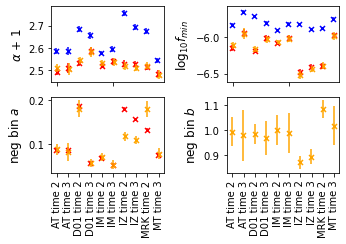

In [6]:
fig, axs = plt.subplots(2,2,figsize=(5, 3.5))

axs[1,0].set_xticks(ticks=np.arange(len(samples)))
axs[1,1].set_xticks(ticks=np.arange(len(samples)))
axs[0,0].set_xticklabels([])
axs[0,1].set_xticklabels([])
axs[1,0].set_xticklabels(labels=names, rotation='vertical')
axs[1,1].set_xticklabels(labels=names, rotation='vertical')

axs[0,0].set_ylabel(r'$\alpha$ + 1', fontsize=12)
axs[0,1].set_ylabel(r'$\log_{10} f_{min}$', fontsize=12)
#axs[0,0].set_ylim(0, 10)
for i in range(len(betas)):
    xs = np.arange(len(betas[0])) + 0.05 * (i - len(betas)/2)
    axs[0,0].errorbar(xs, betas[i], yerr=err_betas[i], linestyle='none', c=colors[i])
    axs[0,0].scatter(xs, betas[i], s=25, marker=markers[i], c=colors[i], label=model_labels[i])
    axs[0,1].errorbar(xs, fmins[i], yerr=err_fmins[i], linestyle='none', c=colors[i])
    axs[0,1].scatter(xs, fmins[i], s=25, marker=markers[i], c=colors[i], label=model_labels[i])
#axs[0,0].legend()

axs[1,0].set_ylabel(r'neg bin $a$', fontsize=12)
#axs[1,0].set_ylim(0, 0.25)
for i, mi in enumerate([1,2]):
    xs = np.arange(len(ass[0])) + 0.05 * (i - len(ass)/2)
    axs[1,0].scatter(xs, ass[i], s=25, marker=markers[i], c=colors[mi], label=model_labels[mi])
    axs[1,0].errorbar(xs, ass[i], yerr=err_ass[i], linestyle='none', c=colors[mi])
    
axs[1,1].set_ylabel(r'neg bin $b$', fontsize=12)
#axs[1,1].set_ylim(1, 1.15)
for i, mi in enumerate([2]):
    xs = np.arange(len(bss[0])) + 0.05 * (i - len(bss)/2)
    axs[1,1].scatter(xs, bss[i], s=25, marker=markers[i], c=colors[mi], label=model_labels[mi])
    axs[1,1].errorbar(xs, bss[i], yerr=err_bss[i], linestyle='none', c=colors[mi])
    
plt.tight_layout()
#plt.savefig('plots/noise/params_'+cell+'.svg')

### BIC and likelihood

In [7]:
def BIC(n_pars, ll, n_samples):
    return n_pars * np.log(n_samples) - 2*ll

In [8]:
lls, bics = [], []
for i, sample in enumerate(samples):
    R = metadata.loc[sample].n_repls
    n_uni, n_count = dt.import_sample_counts(sample, R, 'family', 'count')
    n_samples = np.sum(n_count)
    ll_aux, bic_aux = [], []
    for j, model  in enumerate(models):
        ll_aux.append(results[sample][model]['ll'])
        bic_aux.append(BIC(n_pars[j], ll_aux[-1] * n_samples, n_samples) / n_samples)
    lls.append(ll_aux)
    bics.append(bic_aux)

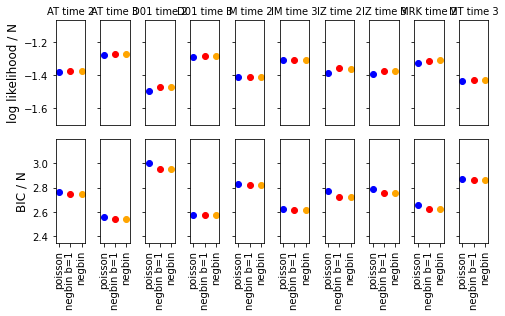

In [9]:
fig, axs = plt.subplots(2,len(samples),figsize=(len(samples)*0.7, 4.5))

axs[0,0].set_ylabel('log likelihood / N', fontsize=12)
axs[1,0].set_ylabel('BIC / N', fontsize=12)

spacing = 0.2
for i, sample in enumerate(samples):
    axs[0,i].set_title(names[i], fontsize=10)
    axs[0,i].set_xticklabels([])
    axs[0,i].set_xticks([])
    axs[0,i].set_xlim(-0.3, 2.3)
    axs[0,i].set_ylim(np.min(lls)-spacing, np.max(lls)+spacing)
    axs[1,i].set_xticks(ticks=np.arange(len(models)))
    axs[1,i].set_xticklabels(labels=model_labels, rotation='vertical')
    axs[1,i].set_xlim(-0.3, 2.3)
    axs[1,i].set_ylim(np.min(bics)-spacing, np.max(bics)+spacing)
    if i > 0:
        axs[0,i].set_yticklabels([])
        axs[1,i].set_yticklabels([])
        
    for j in range(len(models)):
        axs[0,i].scatter(np.arange(len(models))[j], lls[i][j], color=colors[j])
        axs[1,i].scatter(np.arange(len(models))[j], bics[i][j], color=colors[j])
    
plt.tight_layout()
#plt.savefig('plots/noise/BIC_'+cell+'.svg')